# Exploratory Data Analysis

In [1]:
import os
import sys

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)

## Data Preprocessing

### Load the dataset

In [3]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from src import preprocessing

if "df_backup" not in globals():
    df = preprocessing.load_data()
    df_backup = df.copy()
else:
    df = df_backup.copy()  # type: ignore

### Brief Inspection

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [5]:
with pd.option_context('display.max_rows', None):
    display(df.dtypes)

id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

In [6]:
# View first few rows
print("First few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
display(df.describe(include='all'))

First few rows:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N


Missing values:


id                             0
member_id                2260701
loan_amnt                     33
funded_amnt                   33
funded_amnt_inv               33
                          ...   
settlement_status        2226455
settlement_date          2226455
settlement_amount        2226455
settlement_percentage    2226455
settlement_term          2226455
Length: 151, dtype: int64


Summary statistics:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,2260701,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2260668,2.260668e+06,2.260668e+06,2260668,2260668,2093699,2113761,2260668,2.260664e+06,2260668,2260668,2260668,2260668,2260668,126065,2260668,2237342,2260667,2260668,2.258957e+06,2.260639e+06,2260639,2.260668e+06,2.260668e+06,2.260638e+06,1.102166e+06,359156.000000,2.260639e+06,2.260639e+06,2.260668e+06,2.258866e+06,2.260639e+06,2260668,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2258241,2.260668e+06,915358,2260596,2.260668e+06,2.260668e+06,2.260523e+06,580775.000000,2260668.0,2260668,1.207100e+05,120706.000000,115730,2.260639e+06,2.190392e+06,2.190392e+06,1.394538e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.350744e+06,1.394539e+06,1.191818e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.394320e+06,2.190392e+06,1.394539e+06,1.394538e+06,1.394538e+06,2.210638e+06,2.190322e+06,2.185733e+06,2.184597e+06,2.260523e+06,2.260639e+06,2.121597e+06,2.190391e+06,2.190391e+06,2.190392e+06,2.210638e+06,2.187256e+06,519701.000000,1.965233e+06,740359.000000,2.190392e+06,2.190392e+06,2.190392e+06,2.202078e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190391e+06,2.190392e+06,2.202078e+06,2.107011e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190237e+06,2.185289e+06,2.259303e+06,2.260563e+06,2.190392e+06,2.210638e+06,2.210638e+06,2.190392e+06,1.080200e+05,108021.000000,108021.000000,108021,108021.000000,108021.000000,108021.000000,106184.000000,108021.000000,108021.000000,108021.000000,108021.000000,35942.000000,2260668,10917,10917,10917,10917.0

### Data Cleaning

In [7]:
# Remove features that are independent of the target variable
# and those that could cause data leakage
df = preprocessing.drop_cols(df)

df.head()

exit(0)

# Remove features with too many missing values
df = preprocessing.drop_sparse_cols(df)

# Convert date columns to unix timestamps
df = preprocessing.convert_dates(df)

# Impute missing values
df = preprocessing.impute_missing_values(df)


: 

In [ ]:
df.head()

### Categorical Encoding

In [ ]:
from src.feature_engineering import encode_target, frequency_encoding, onehot_encoding

# Encode target variable and categorical features
df = encode_target(df)
df = onehot_encoding(df)
df = frequency_encoding(df)

### Drop highly correlated feature pairs

In [ ]:
from src import algebra, visualize
from src.feature_engineering import drop_high_corr

corr = algebra.correlation_matrix(df)

# plot correlation matrix
visualize.correlation_matrix(corr)

df = drop_high_corr(df, corr)

### Feature Engineering

In [173]:
from src.feature_engineering import frequency_encoding, new_features

df = new_features(df)

### Scale feature values

In [174]:
from src.preprocessing import scale_features

df = scale_features(df)

### Take another peak

In [ ]:
df.head()

### Handle data imbalance

In [ ]:
visualize.class_dist(df)

In [177]:
from src import training

X_resampled, y_resampled = training.resample(df)

### Split the data

In [178]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

### Feature Selection using RFE

In [181]:
# Takes about 5.5 minutes to run

# Initialize the model for RFE
from sklearn.feature_selection import RFE
from src.model import create_model

rfe_model = create_model(eval_metric='logloss')

# Initialize RFE
rfe = RFE(estimator=rfe_model, n_features_to_select=10)

# Fit RFE
rfe.fit(X_train, y_train)

# Transform the data
cols = X_train.columns[rfe.support_]
X_train = pd.DataFrame(rfe.transform(X_train), columns=cols) # type: ignore
X_test = pd.DataFrame(rfe.transform(X_test), columns=cols) # type: ignore

## Training

### Train the model

In [ ]:
model = create_model(eval_metric='logloss')

model.fit(X_train, y_train)

## Inference
### Make predictions

In [152]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

## Evaluation

### Accuracy

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

### Classification Report

In [ ]:
# Classification report
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))

### Confusion Matrix

In [ ]:
# Confusion matrix
visualize.confusion_matrix(y_test, y_pred)

### ROC Curve

In [ ]:
from sklearn.metrics import roc_auc_score

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
visualize.roc_curve(y_test, y_proba, roc_auc)

In [ ]:
# ### Cross-Validation

from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation ROC-AUC Score: {cv_scores.mean():.4f}")

## Feature importance

/Users/brendan/.pyenv/versions/3.12.0/envs/credit-risk/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/brendan/.pyenv/versions/3.12.0/envs/credit-risk/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


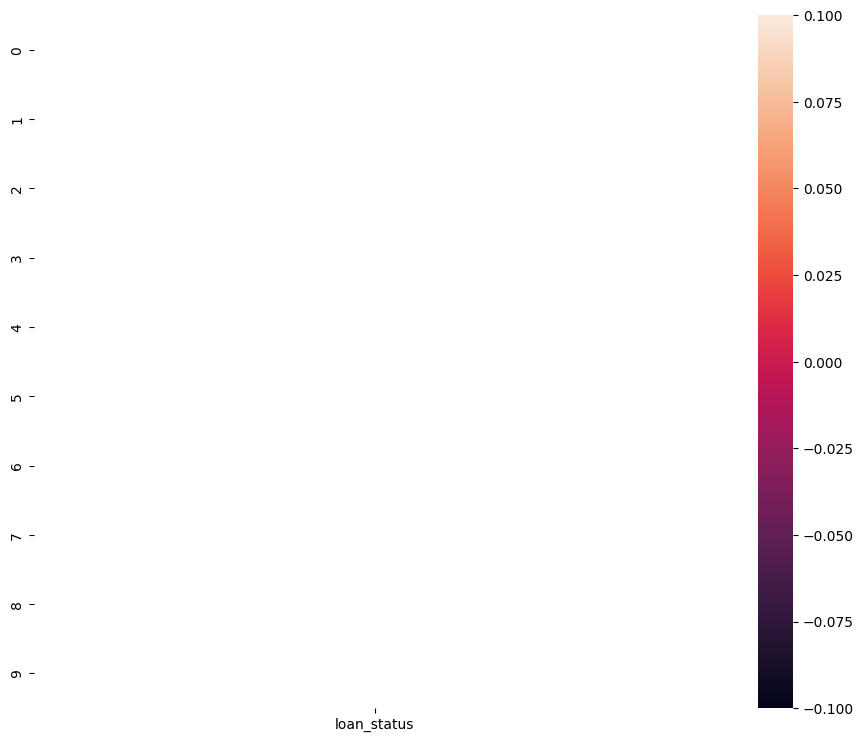

In [157]:
# calculate correlations between the features in X_train and the target variable y_train
df_train = pd.concat([X_train, y_train])
correlations = df_train.corr()['loan_status'].sort_values().to_frame()

# plot the correlations
visualize.correlations(correlations.drop('loan_status'))

In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(model, X_train, y_train, n_repeats=3, random_state=42)

# Get importance values
importances = result['importances_mean']

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Display the feature importances DataFrame
with pd.option_context('display.max_rows', None):
    display(feature_importances)


,Feature,Importance
3,None,0.241361
7,None,0.111003
1,None,0.062926
4,None,0.060811
6,None,0.057343
5,None,0.053841
0,None,0.048063
9,None,0.040869
8,None,0.036115
2,None,0.033994


## Hyperparameter Tuning

### Grid search

In [128]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 0.9],
}

In [129]:
# Initialize GridSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

grid_search = GridSearchCV(
    estimator=create_model(eval_metric='logloss'),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

### Best Model

In [130]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC-AUC Score: {grid_search.best_score_:.4f}")

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best ROC-AUC Score: 0.9863


### Retrain with these hyperparameters

In [131]:
best_params = grid_search.best_params_
model_best = create_model(**best_params)
model_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Evaluate the optimized model

In [132]:
# Predict on test data
y_pred_best = model_best.predict(X_test)
y_proba_best = model_best.predict_proba(X_test)[:,1]

# Accuracy
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Optimized Accuracy: {accuracy_best:.4f}")

print("Optimized Classification Report:\n", classification_report(y_test, y_pred_best))

Optimized Accuracy: 0.9382
Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94    215032
           1       0.94      0.94      0.94    215682

    accuracy                           0.94    430714
   macro avg       0.94      0.94      0.94    430714
weighted avg       0.94      0.94      0.94    430714



Optimized ROC-AUC Score: 0.9862


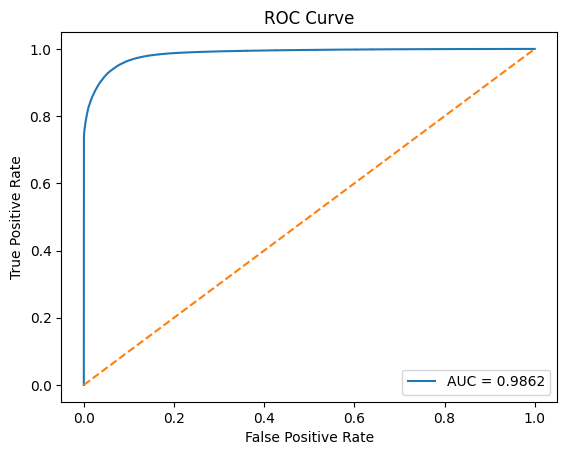

In [133]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Optimized ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
visualize.roc_curve(y_test, y_proba, roc_auc)